# Setting Up and Verifying TensorFlow with Required Libraries

In [91]:
import numpy as np

In [92]:
import matplotlib.pyplot as plt

In [93]:
import tensorflow

In [94]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, GlobalAvgPool2D, DepthwiseConv2D, ReLU
from tensorflow.keras.models import Model
import glob

In [95]:
tensorflow.__version__

'2.18.0'

# Prepare Data

In [96]:
import cv2 as cv

In [97]:
import os
# lấy danh sách đường dẫn
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir) if os.path.isdir(os.path.join(a_dir, name))]

### **Giải thích chi tiết đoạn code:**

- **Mô tả:** Import thư viện `os`, cung cấp các chức năng để tương tác với hệ điều hành.
- **Mục đích:** Dùng để làm việc với hệ thống file và thư mục.

- **Mô tả:** Định nghĩa một hàm có tên `get_immediate_subdirectories` với một tham số `a_dir`.
- **Mục đích:** Trả về danh sách các thư mục con (subdirectories) nằm trực tiếp trong `a_dir` (không bao gồm các file).

- **`os.listdir(a_dir)`**:  
  - Trả về danh sách **tất cả các file và thư mục** trong thư mục `a_dir` (không phân biệt thư mục hay file).
  
- **Duyệt từng `name` trong danh sách trên**:
  - `os.path.join(a_dir, name)`: Kết hợp `a_dir` với `name` để tạo đường dẫn đầy đủ (`full_path`).
  - `os.path.isdir(full_path)`: Kiểm tra xem `full_path` có phải là thư mục không.
  - **Nếu `name` là thư mục**, nó sẽ được thêm vào danh sách trả về.

### **Tóm tắt** 
**Hàm `get_immediate_subdirectories(a_dir)`** trả về danh sách **các thư mục con trực tiếp** của `a_dir` (bỏ qua file).

**Công dụng:** Hữu ích khi cần liệt kê các thư mục con trong một thư mục cha để xử lý dữ liệu, duyệt thư mục, hoặc tổ chức file

In [98]:
def getData( link ):

  # Khoi tao danh sach chua du lieu, x la anh, y la nhan
  X = []  #Image
  y = []  #Label

  list_name = get_immediate_subdirectories(link)
  # Ham get_immediate_subdirectories(link) tra ve danh sach (list) cac thu muc con co trong link, moi thu muc con chua anh cua lop, ten thu muc lam nhan

  for label in list_name: #Duyet qua list cac nhan
    # lấy link ảnh
    for file_name in glob.glob(link + "/" + label+"/*"):
      img = cv.imread(file_name)
      # đọc ảnh, OpenCV đọc ảnh mặc định ở định dạng BGR.
      img_cvt = cv.cvtColor(img,cv.COLOR_BGR2RGB)
      # chuyển về dạng RGB
      img_cvt = cv.resize(img_cvt,(224,224))
      # đưa về size 224 X 224 x 3, kích thước này thường dùng trong mô hình deep learning như ResNet, VGG, MobileNet.
      X.append(img_cvt)
      y.append(label)

  return X,y

- Hàm `getData(link)` nhận một đường dẫn link chứa nhiều thư mục con (mỗi thư mục chứa ảnh của một lớp).
- Trả về:
  - X: Danh sách ảnh đã được xử lý.
  - y: Danh sách nhãn tương ứng của ảnh.

In [99]:
#lấy từng bộ data
X_train, y_train = getData("Vegetable Images/train")
X_test, y_test = getData("Vegetable Images/test")
X_val, y_val = getData("Vegetable Images/validation")

In [100]:
# In ra kiểu dữ liệu và số lượng điểm dữ liệu của các tập
print("Training set:")
print(f"X_train type: {type(X_train)}, Length: {len(X_train)}")
print(f"y_train type: {type(y_train)}, Length: {len(y_train)}")

print("\nTesting set:")
print(f"X_test type: {type(X_test)}, Length: {len(X_test)}")
print(f"y_test type: {type(y_test)}, Length: {len(y_test)}")

print("\nValidation set:")
print(f"X_val type: {type(X_val)}, Length: {len(X_val)}")
print(f"y_val type: {type(y_val)}, Length: {len(y_val)}")

Training set:
X_train type: <class 'list'>, Length: 21993
y_train type: <class 'list'>, Length: 21993

Testing set:
X_test type: <class 'list'>, Length: 3002
y_test type: <class 'list'>, Length: 3002

Validation set:
X_val type: <class 'list'>, Length: 3000
y_val type: <class 'list'>, Length: 3000


In [101]:
# Chọn một ảnh ngẫu nhiên từ tập X_train
index = np.random.randint(0, len(X_train))  # Chọn một index ngẫu nhiên
image = X_train[index]  # Lấy ảnh từ danh sách X_train
label = y_train[index]  # Lấy nhãn tương ứng

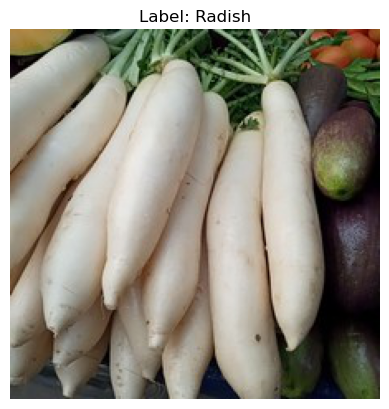

In [102]:
# Hiển thị ảnh
plt.imshow(image)
plt.title(f"Label: {label}")  # Hiển thị nhãn của ảnh
plt.axis("off")  # Ẩn trục tọa độ
plt.show()

In [103]:
# Chuyển về dạng array
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [104]:
#Kiểm tra shape của các tập
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((21993, 224, 224, 3),
 (21993,),
 (3002, 224, 224, 3),
 (3002,),
 (3000, 224, 224, 3),
 (3000,))

In [105]:
from tensorflow.keras.utils import to_categorical # Dùng để chuyển nhãn dạng số nguyên thành dạng one-hot vector (chưa sử dụng trong đoạn code này).

# Tạo một danh sách các nhãn dạng số nguyên
labels = np.arange(15) # Tạo một danh sách các số nguyên từ 0 đến 14 (tức là có 15 nhãn).
# Lấy danh sách label
names = np.unique(y_train) # Trả về danh sách các nhãn duy nhất có trong y_train (tên thư mục ban đầu).

name_label={} # Ánh xạ từ tên nhãn → số nguyên
label_name = {} # Ánh xạ từ số nguyên → tên nhãn
for i in range(15):
  name_label[names[i]] = labels[i]
  label_name[labels[i]] = names[i]
y_train_encode = []
y_test_encode = []
y_val_encode = []
for label in y_train:
  y_train_encode.append( name_label[label] )
for label in y_val:
  y_val_encode.append( name_label[label] )
for label in y_test:
  y_test_encode.append( name_label[label] )

y_train_encode = np.array(y_train_encode)
y_test_encode = np.array(y_test_encode)
y_val_encode = np.array(y_val_encode)

#đưa về dạng vecto 1 chieu
y_train_encode = np.reshape(y_train_encode,(y_train_encode.shape[0],1))
y_val_encode = np.reshape(y_val_encode,(y_val_encode.shape[0],1))
y_test_encode = np.reshape(y_test_encode,(y_test_encode.shape[0],1))

In [106]:
label_name

{0: 'Bean',
 1: 'Bitter_Gourd',
 2: 'Bottle_Gourd',
 3: 'Brinjal',
 4: 'Broccoli',
 5: 'Cabbage',
 6: 'Capsicum',
 7: 'Carrot',
 8: 'Cauliflower',
 9: 'Cucumber',
 10: 'Papaya',
 11: 'Potato',
 12: 'Pumpkin',
 13: 'Radish',
 14: 'Tomato'}

In [107]:
from tensorflow.keras import layers
# input_shape: kich thuoc anh dau vao, n_classes: so lop phan loai
def mobilenet(input_shape, n_classes):
    # khoi mobilenet, gom depthwise convolution de giam so luong trong so va  pointwise convolution de lam tang chieu sau
    # giam so lượng trọng số giúp giảm bộ nhớ cho mô hình
    # tăng chiều sấu cho feature map để trích xuất các đặc trưng phức từ từ ảnh giúp tăng độ chính xác và hiệu suất cảu mô hình
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    #  Với mỗi kênh đầu vào, lớp này sẽ áp dụng một kernel (bộ lọc) duy nhất để tính toán output cho kênh đó.
    #Điều này giúp giảm số lượng tham số trong mô hình và tăng tốc độ tính toán
    x = BatchNormalization()(x)
    #chuẩn hóa giá trị đầu vào trên mỗi batch dữ liệu bằng cách trung bình hóa giá trị đầu vào trên batch và phép chia chuẩn hóa đó.
    x = ReLU()(x)
    # giữ lại đặc trưng quan trọng

    x = Conv2D(f, 1, strides=1, padding='same')(x)
    #kết hợp các thông tin đặc trưng giữa các kênh của tensor x lại với nhau, tạo ra một tensor đầu ra mới với số lượng kênh là f
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  #  lớp convolution với 32 bộ lọc, kích thước bộ lọc là 3x3, bước trượt là 2 và độ lề là same.

  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)
  x = layers.Dropout(0.3)(x)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)
  x = layers.Dropout(0.3)(x)

  x = mobilenet_block(x, 256, 2)
  for _ in range(5):
    x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  x = mobilenet_block(x, 512)

  x = GlobalAvgPool2D()(x)
  # thực hiện phép pooling toàn cục (global average pooling) trên đầu ra của lớp trước đó.

  output = Dense(n_classes)(x)
  #là lớp fully connected với số lượng đầu ra là n_classes

  model = Model(input, output)
  return model

In [108]:
model = mobilenet((224,224,3),15) # Định dạng kích thước ảnh đầu vào (224x224 pixel, 3 kênh màu RGB).Số lớp đầu ra (tương ứng với 15 loại rau củ quả trong tập dữ liệu).
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_13             │ (None, 112, 112, 32)   │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_14             │ (None, 56, 56, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_30 (ReLU)                 │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_31 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_15             │ (None, 56, 56, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 977,807 (3.73 MB)

 Trainable params: 965,135 (3.68 MB)

 Non-trainable params: 12,672 (49.50 KB)

In [109]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Định nghĩa số epochs
epochs = 50

# Thiết lập callback để lưu model có val_accuracy cao nhất
checkpoint = ModelCheckpoint(filepath='best_model.keras', 
                             monitor='accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

# Compile mô hình
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Huấn luyện mô hình với callback
history = model.fit(X_train, y_train_encode, 
                    epochs=epochs, 
                    batch_size=64, 
                    validation_data=(X_val, y_val_encode), 
                    callbacks=[checkpoint])

Epoch 1/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4513 - loss: 1.6344
Epoch 1: accuracy improved from -inf to 0.64311, saving model to best_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 39s 84ms/step - accuracy: 0.4519 - loss: 1.6328 - val_accuracy: 0.0667 - val_loss: 5.0755
Epoch 2/50
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8747 - loss: 0.4019
Epoch 2: accuracy improved from 0.64311 to 0.89910, saving model to best_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8748 - loss: 0.4014 - val_accuracy: 0.4413 - val_loss: 2.4347
Epoch 3/50
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9383 - loss: 0.2026
Epoch 3: accuracy improved from 0.89910 to 0.94066, saving model to best_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9383 - loss: 0.2025 - val_accuracy: 0.6640 - val_loss: 1.4531
Epoch 4/50
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9522 - loss: 0.1636
Epoch 4: accuracy improved from 0.94066 to 

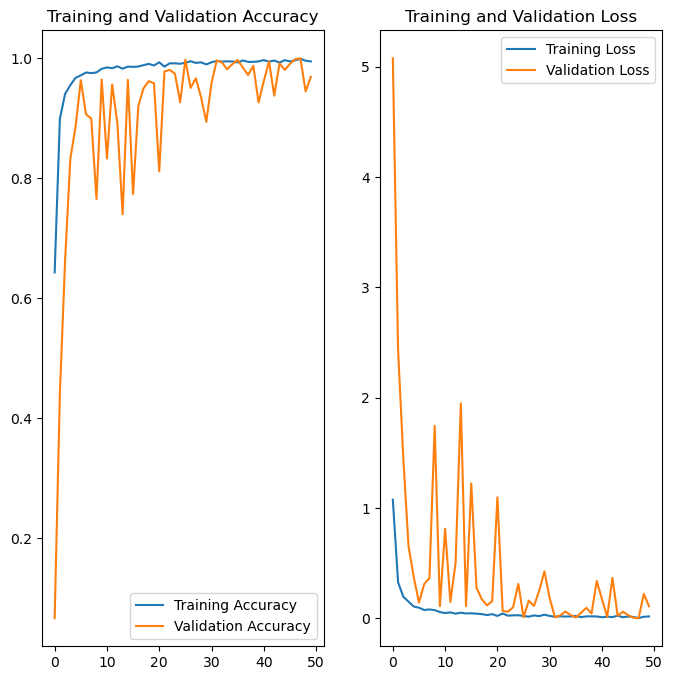

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [111]:
model.save('mobilenet_model.h5')

In [112]:
import tensorflow
saved_model = tensorflow.keras.models.load_model("mobilenet_model.h5")

In [113]:
saved_model.evaluate(X_test,y_test_encode)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9747 - loss: 0.0801


[0.13640214502811432, 0.9606928825378418]

In [114]:
out = saved_model.predict(X_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [115]:
output = np.zeros((y_test_encode.shape))
for i in range(out.shape[0]):
    output[i] = np.argmax(out[i])

In [116]:
X_test.shape, y_test_encode.shape, output.shape

((3002, 224, 224, 3), (3002, 1), (3002, 1))

In [117]:
output

array([[ 5.],
       [ 5.],
       [ 5.],
       ...,
       [13.],
       [13.],
       [13.]])

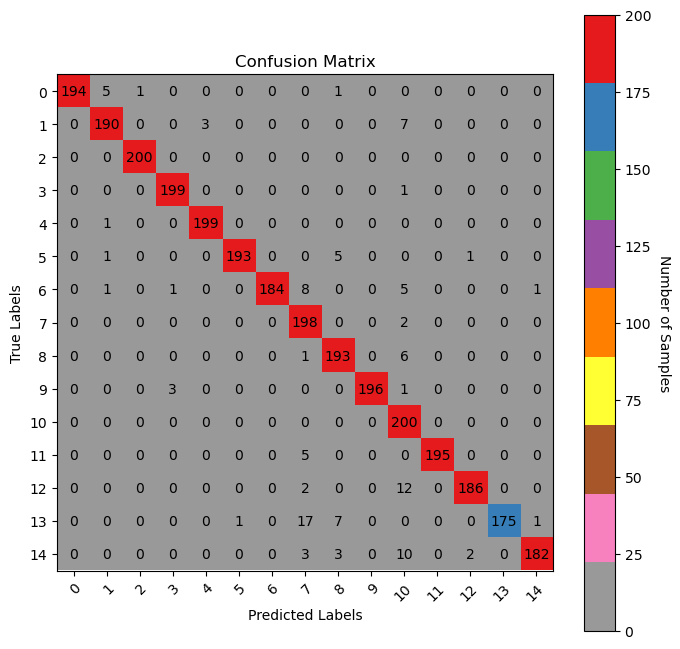

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ground truth labels
y_true = y_test_encode

# predicted labels
y_pred = output
# create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# define labels for plotting
labels = [str(i) for i in range(15)]

# plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Set1_r')

# show all ticks and label them with corresponding list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

# set plot title and axis labels
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Number of Samples", rotation=-90, va="bottom")

# show the plot
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Broccoli


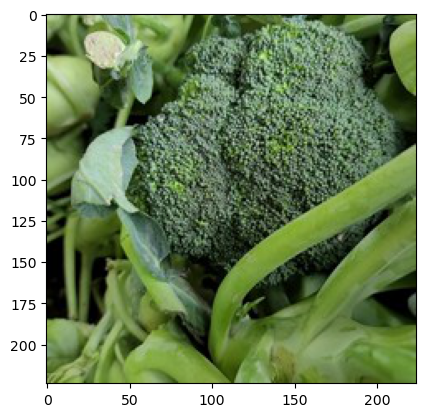

In [119]:
index = np.random.randint(X_test.shape[0])

# img = cv.imread(X_test[index])
# img_cvt = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# img_resize = cv.resize(img_cvt,(224,224))

list_img = []
list_img.append(X_test[index])
list_img = np.array(list_img)
pred = saved_model.predict(list_img)
pred_labels = np.argmax(pred, axis=1)
print(label_name.get(pred_labels[0]))

plt.imshow(X_test[index])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[[ -9.221193  -10.518082   -3.7028131  -6.471983  -10.170177  -10.169101
   -6.050224  -12.630965  -13.668381   -4.881631   14.153883  -14.3147335
  -11.205682  -14.680847   -9.831439 ]]
Papaya


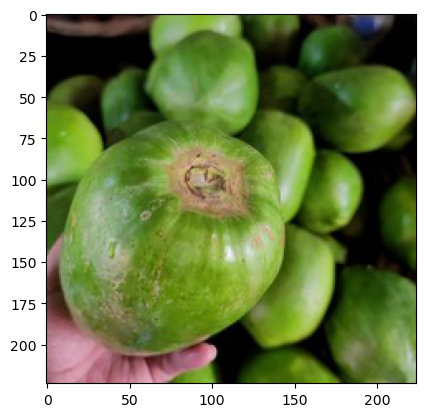

In [120]:
import cv2 as cv
img = cv.imread("Vegetable Images/test/Papaya/1198.jpg")
img_cvt = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resize = cv.resize(img_cvt,(224,224))

list_img = []
list_img.append(img_resize)
list_img = np.array(list_img)
pred = saved_model.predict(list_img)
print(pred)

pred_labels = np.argmax(pred, axis=1)
print(label_name.get(pred_labels[0]))

plt.imshow(img_resize)
plt.show()

In [121]:
import cv2 as cv
img1 = cv.imread("Vegetable Images/test/Radish/radish.jpg")

img_cvt1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img_resize1 = cv.resize(img_cvt1,(224,224))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[-16.93512    -6.7824807  -8.68005    -6.684117   -7.973017   -7.6847587
  -31.782677    6.483823    9.733898  -16.402332  -13.208263  -25.92246
   -6.9656944  13.403339  -20.13073  ]]
Radish


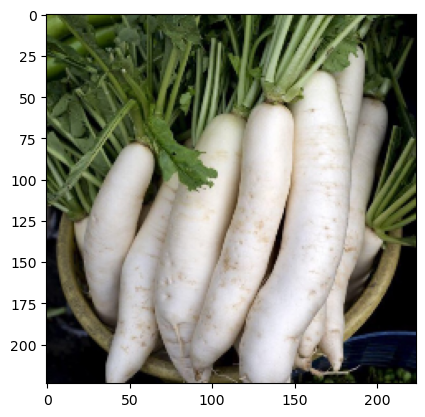

In [122]:
list_img = []
list_img.append(img_resize1)
list_img = np.array(list_img)
pred = saved_model.predict(list_img)
print(pred)

pred_labels = np.argmax(pred, axis=1)
print(label_name.get(pred_labels[0]))

plt.imshow(img_resize1)
plt.show()